In [1]:
import numpy as np, matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# ── load arrays ───────────────────────────────────────────
e = np.load('output_model_directory/signal_data_e_v2_preserve.npy')   # (N,4,14)
p = np.load('output_model_directory/signal_data_p_v2_preserve.npy')   # (N,4,13)
m = np.load('output_model_directory/signal_models_v2_preserve.npy')   # (N,)

mask_short = m == "600_290_0p1ns"
mask_long  = m == "600_290_10ns"

e_s, e_l = e[mask_short], e[mask_long]
p_s, p_l = p[mask_short], p[mask_long]

In [4]:
# helper: drop rows whose energy (feature 0) is zero for the given slot
def keep_by_E(arr):
    out = []
    for slot in range(4):
        slot_rows = arr[arr[:, slot, 0] != 0.0, slot, :]   # (N_eff, F)
        out.append(slot_rows)
    return out

e_s, e_l = map(keep_by_E, (e_s, e_l))     # each → list[slot] of (N_eff,14)
p_s, p_l = map(keep_by_E, (p_s, p_l))     # each → list[slot] of (N_eff,13)

In [5]:
# ── additional loads ──────────────────────────────────────────
d_e = np.load('train_data_e_preserve.npy')        # (N,4,15)  ← DATA
d_p = np.load('train_data_p_preserve.npy')        # (N,4,13)
d_e, d_p = map(keep_by_E, (d_e, d_p))    

In [14]:
def bounds(*arrs):
    d = np.concatenate(arrs)
    mu, s = d.mean(), d.std()
    return mu - 4*s, mu + 4*s

In [8]:
hkw = dict(bins=20, histtype="step", lw=1.4, density=True)

In [15]:
electron_labels = [
    'electron_E', 'electron_pt', 'electron_eta', 'electron_phi',
    'electron_time',
    'electron_d0', 'electron_z0', 'electron_dpt',
    'electron_nPIX', 'electron_nMissingLayers',
    'electron_chi2', 'electron_numberDoF',
    'electron_f1', 'electron_f3'               # 0-13 → matches signal
]
photon_labels = [
    'photon_E', 'photon_pt', 'photon_eta', 'photon_phi',
    'photon_time',
    'photon_maxEcell_E',
    'photon_f1', 'photon_f3', 'photon_r1', 'photon_r2',
    'photon_etas1', 'photon_phis1', 'photon_z'
]

# ── electrons ────────────────────────────────────────────────
with PdfPages("600_290_lifetime_overlay_filtered.pdf") as pdf:
    for slot in range(4):
        for feat in range(14):                       # 0-13 only
            lo, hi = bounds(e_s[slot][:, feat],
                             e_l[slot][:, feat],
                             d_e[slot][:, feat])
            plt.figure()
            plt.hist(d_e[slot][:, feat], range=(lo, hi), label="data", **hkw)
            plt.hist(e_s[slot][:, feat], range=(lo, hi), label="0.1 ns", **hkw)
            plt.hist(e_l[slot][:, feat], range=(lo, hi), label="10 ns", **hkw)
            plt.xlim(lo, hi)
            plt.title(f"Electron slot {slot} – {electron_labels[feat]}")
            plt.xlabel(electron_labels[feat]); plt.ylabel("pdf"); plt.legend()
            pdf.savefig(); plt.close()

    # ── photons ───────────────────────────────────────────────
    for slot in range(4):
        for feat in range(13):
            lo, hi = bounds(p_s[slot][:, feat],
                             p_l[slot][:, feat],
                             d_p[slot][:, feat])
            plt.figure()
            plt.hist(d_p[slot][:, feat], range=(lo, hi), label="data", **hkw)
            plt.hist(p_s[slot][:, feat], range=(lo, hi), label="0.1 ns", **hkw)
            plt.hist(p_l[slot][:, feat], range=(lo, hi), label="10 ns", **hkw)
            plt.xlim(lo, hi)
            plt.title(f"Photon slot {slot} – {photon_labels[feat]}")
            plt.xlabel(photon_labels[feat]); plt.ylabel("pdf"); plt.legend()
            pdf.savefig(); plt.close()

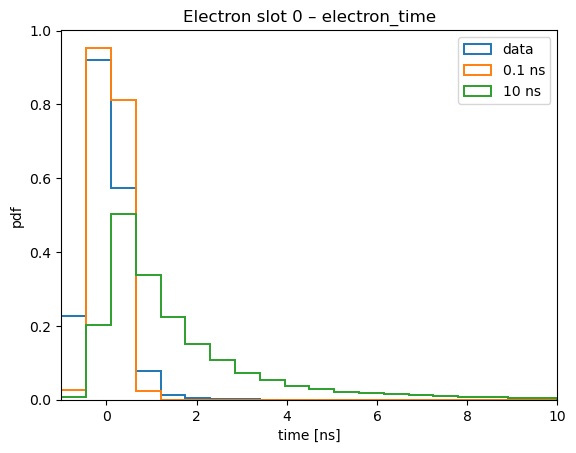

In [13]:
# ── prep (reuse previous helpers / loads) ───────────────────
feat  = 4                         # time index
hkw   = dict(bins=20, histtype="step", lw=1.4, density=True)

d_e   = keep_by_E(np.load('train_data_e_preserve.npy'))   # raw data

# ── time-only overlay (slot 0) ──────────────────────────────
slot = 0
d, s, l = d_e[slot][:, feat], e_s[slot][:, feat], e_l[slot][:, feat]

lo, hi = -1, 10
plt.figure()
plt.hist(d, range=(lo, hi), label="data",   **hkw)
plt.hist(s, range=(lo, hi), label="0.1 ns", **hkw)
plt.hist(l, range=(lo, hi), label="10 ns",  **hkw)
plt.xlim(lo, hi)
plt.title("Electron slot 0 – electron_time")
plt.xlabel("time [ns]")
plt.ylabel("pdf")
plt.legend()
plt.show()


In [ ]:
def corr_with_E(datasets, labels, name):
    """
    datasets : list like [data_arr, short_arr, long_arr]
               each element is list[slot] → (N_eff, F)
    labels   : feature names (len = F)
    """
    for slot in range(4):
        # Pearson r for every feature except energy itself
        r = [ [np.corrcoef(ds[slot][:,0], ds[slot][:,f])[0,1]
                if ds[slot].size else np.nan           # guard empty slots
                for f in range(1, ds[slot].shape[1]) ] # skip f=0
              for ds in datasets ]                     # → 3×(F‑1)

        x      = np.arange(len(labels)-1)
        width  = 0.25
        plt.figure(figsize=(10,4))
        plt.bar(x-width, r[0],  width, label="data")
        plt.bar(x,         r[1], width, label="0.1 ns")
        plt.bar(x+width,  r[2],  width, label="10 ns")
        plt.xticks(x, labels[1:], rotation=90)
        plt.ylim(-1,1)
        plt.ylabel("Pearson r(E, feature)")
        plt.title(f"{name} slot {slot} – correlation with energy")
        plt.legend(); plt.tight_layout()
        pdf.savefig(); plt.close()

# append after the photon loop, still inside the same PdfPages block
corr_with_E([d_e, e_s, e_l], electron_labels, "Electron")
corr_with_E([d_p, p_s, p_l], photon_labels,  "Photon")

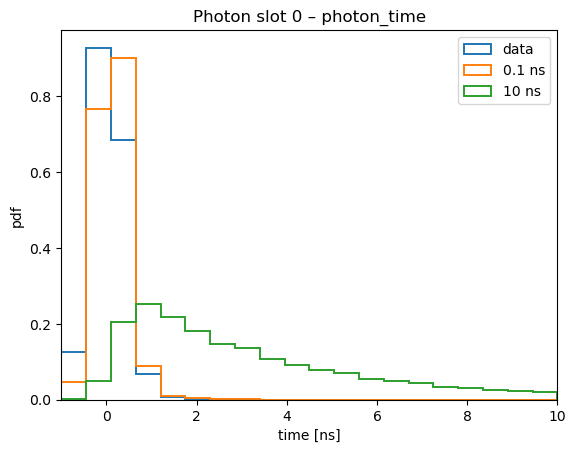

In [17]:
# ── prep (reuse previous helpers / loads) ───────────────────
feat  = 4                         # time index
hkw   = dict(bins=20, histtype="step", lw=1.4, density=True)

d_p   = keep_by_E(np.load('train_data_p_preserve.npy'))   # raw data

# ── time-only overlay (slot 0) ──────────────────────────────
slot = 0
d, s, l = d_p[slot][:, feat], p_s[slot][:, feat], p_l[slot][:, feat]

lo, hi = -1, 10
plt.figure()
plt.hist(d, range=(lo, hi), label="data",   **hkw)
plt.hist(s, range=(lo, hi), label="0.1 ns", **hkw)
plt.hist(l, range=(lo, hi), label="10 ns",  **hkw)
plt.xlim(lo, hi)
plt.title("Photon slot 0 – photon_time")
plt.xlabel("time [ns]")
plt.ylabel("pdf")
plt.legend()
plt.show()
